In [55]:
# Python 3.8.8

# Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

# Dendrometer data


In [56]:
# read the file and define some basic stuff 
dendrometer = pd.read_excel('dendrometer_hourly.xlsx')
dendrometer['datetime'] = pd.to_datetime(dendrometer['datetime'], dayfirst=True)
dendrometer = dendrometer.set_index('datetime')
dendrometer = dendrometer.sort_index()
# remove unnecessary columns
dendrometer = dendrometer.drop(['hour', 'date', 'sensor_type', 'variety'], axis=1)

# add species column
# Define a function to extract species from project_name
def get_species(project_name):
    if '3' in project_name:
        return 'ms-3'
    elif '4' in project_name:
        return 'ms-4'
    else:
        return None

# Apply the function to create the new 'species' column
dendrometer['species'] = dendrometer['project_name'].apply(get_species)

#change project_name values to irrigation treatment values
# Define the mapping of values to replace
mapping = {
    'כחול 3': 1.2,
    'ירוק 3': 1.0,
    'צהוב 3': 0.7,
    'סגול 3': 1.4,
    'שחור 3': 0.0,
    'אדום 3': 0.5,
    'צהוב 4': 0.7,
    'כחול 4': 1.2,
    'שחור 4': 0.0,
    'סגול 4': 1.4,
    'ירוק 4': 1.0,
    'אדום 4': 0.5
}

# Replace values in the 'project_name' column using the mapping
dendrometer['project_name'] = dendrometer['project_name'].replace(mapping)

# Rename the columns
dendrometer.rename(columns={'project_name': 'treatment', "format": "dendrometer"}, inplace=True)

In [57]:
# Grouping by 'treatment' and 'species', then counting unique 'sensor_id' for each group - these are the technical replicates
sensor_counts = dendrometer.groupby(['treatment', 'species'])['sensor_id'].nunique()
print('dendrometer data:')
print('-----------------------')
print('shape:', dendrometer.shape)
print('-----------------------')
print(sensor_counts)



dendrometer data:
-----------------------
shape: (127588, 4)
-----------------------
treatment  species
0.0        ms-3       3
           ms-4       3
0.5        ms-3       3
           ms-4       3
0.7        ms-3       3
           ms-4       3
1.0        ms-3       3
           ms-4       3
1.2        ms-3       3
           ms-4       3
1.4        ms-3       3
           ms-4       3
Name: sensor_id, dtype: int64


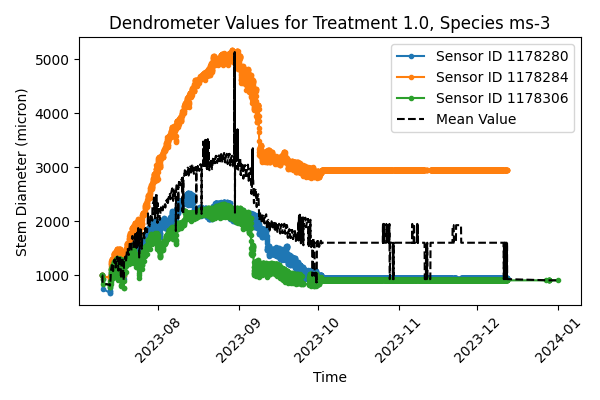

In [58]:
# exploratory research - change the treatment and species value to look for somthing interesting
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize = (6,4))
# Filter the DataFrame for the specified treatment and species
filtered_data = dendrometer[(dendrometer['treatment'] == 1.0) & (dendrometer['species'] == 'ms-3')]

# Group by 'sensor_id'
grouped_data = filtered_data.groupby('sensor_id')

# Calculate the mean value for each timestamp across the three sensors
mean_values = filtered_data.groupby(filtered_data.index)['dendrometer'].mean()

# Plot each group separately with a different color
for sensor_id, group in grouped_data:
    plt.plot(group.index, group['dendrometer'], label=f"Sensor ID {sensor_id}", marker='.')

# Plot the mean value line
plt.plot(mean_values.index, mean_values.values, color='black', linestyle='--', label="Mean Value")

# Set plot labels and legend
plt.xlabel('Time')
plt.ylabel('Stem Diameter (micron)')
plt.title('Dendrometer Values for Treatment 1.0, Species ms-3')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show plot
plt.show()


In [59]:
# filter the data for the specified treatment and species
filtered_data = dendrometer[(dendrometer['treatment'].isin([0.0, 1.0])) & (dendrometer['species'] == 'ms-3')]

In [60]:
# we want to add the missing rows so that we can see the gaps in the data

# Group by 'sensor_id'
grouped_data = filtered_data.groupby('sensor_id')

# List to store modified dataframes for each sensor_id
modified_data = []

# Iterate over each group
for sensor_id, group in grouped_data:
    # Aggregate the data within each group to handle duplicates - 29/10 clock shift play a role here *-*
    aggregated_group = group.groupby(group.index).mean()
    
    # Resample the aggregated group at hourly intervals
    resampled_group = aggregated_group.resample('H').asfreq()
    
    # Fill NaN in 'dendrometer' column
    resampled_group['dendrometer'] = resampled_group['dendrometer'].fillna(value=pd.NA)
    
    # Insert rows for missing timestamps
    expected_index = pd.date_range(start=resampled_group.index.min(), end=resampled_group.index.max(), freq='H')
    missing_timestamps = expected_index.difference(resampled_group.index)
    for ts in missing_timestamps:
        # Extract treatment value for the group
        treatment_value = group['treatment'].iloc[0]
        # Create a new row with NaN value in 'dendrometer' column and the respective sensor_id and treatment
        new_row = pd.DataFrame({'dendrometer': pd.NA, 'treatment': treatment_value}, index=[ts])
        # Append the new row to the dataframe
        resampled_group = pd.concat([resampled_group, new_row])
    
    # Add sensor_id column
    resampled_group['sensor_id'] = sensor_id
    
    # Store the modified group
    modified_data.append(resampled_group)

# Concatenate the modified data for all sensor_ids into a single DataFrame
final_df = pd.concat(modified_data)

# Sort the DataFrame by 'sensor_id'
final_df.sort_values(by='sensor_id', inplace=True)

# Define a dictionary to map sensor_id to treatment
sensor_to_treatment = {
    1178309: 0.0,
    1178287: 0.0,
    1178290: 0.0,
    1178306: 1.0,
    1178284: 1.0,
    1178280: 1.0
}

# Map treatment values based on sensor_id
final_df['treatment'] = final_df['sensor_id'].map(sensor_to_treatment)




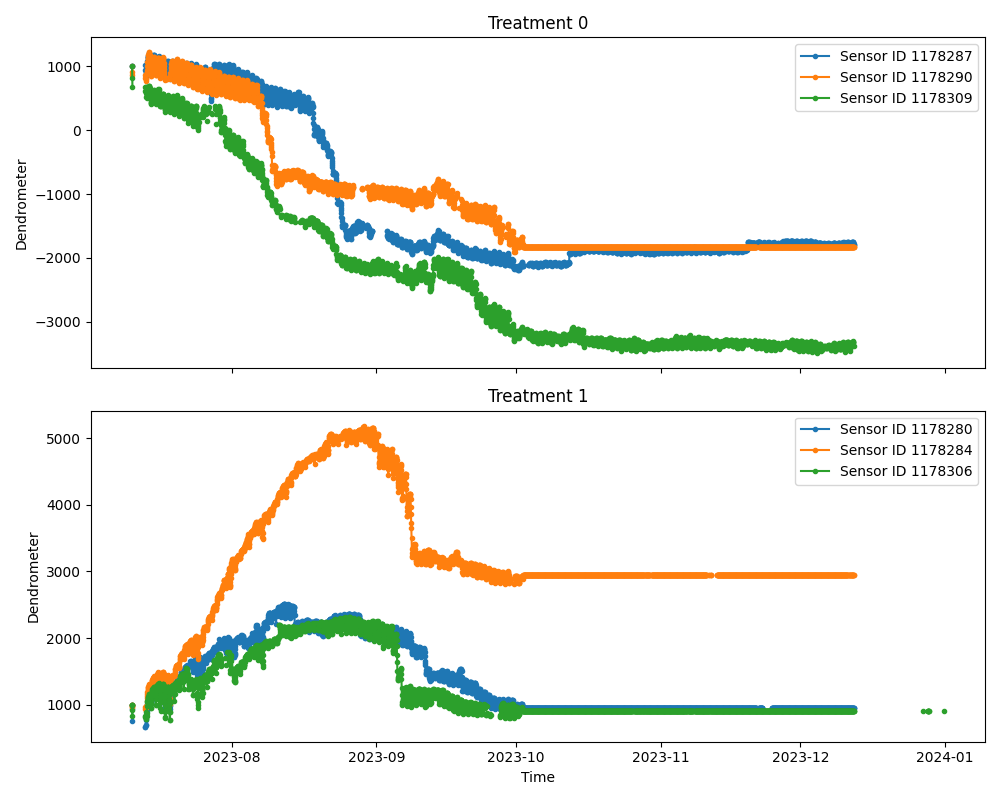

In [61]:
# now we can see the gaps clearly - 

# Filter the DataFrame for treatment 0 and treatment 1
treatment_0_df = final_df[final_df['treatment'] == 0.0]
treatment_0_df = treatment_0_df.sort_index()
treatment_1_df = final_df[final_df['treatment'] == 1.0]
treatment_1_df = treatment_1_df.sort_index()

# Create two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Plot for treatment 0
for sensor_id, group in treatment_0_df.groupby('sensor_id'):
    group_data = group['dendrometer']
    group_data = group_data.where(pd.notna(group_data), None)  # Convert NaN to None for plotting
    axes[0].plot(group_data.index, group_data.values,marker='.', label=f"Sensor ID {sensor_id}")

axes[0].set_title('Treatment 0')
axes[0].set_ylabel('Dendrometer')
axes[0].legend()

# Plot for treatment 1
for sensor_id, group in treatment_1_df.groupby('sensor_id'):
    group_data = group['dendrometer']
    group_data = group_data.where(pd.notna(group_data), None)  # Convert NaN to None for plotting
    axes[1].plot(group_data.index, group_data.values, marker='.',label=f"Sensor ID {sensor_id}")

axes[1].set_title('Treatment 1')
axes[1].set_ylabel('Dendrometer')
axes[1].set_xlabel('Time')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


In [18]:
#lets try filling the gaps
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def fillna_randomforest(series):
    # Ensure the series index is a datetime object
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex")
    
    # Split series into observed and missing values
    observed = series.dropna()
    missing = series[series.isna()]
    
    # Extracting time-based features
    def create_features(index):
        return np.array([index.hour, index.day, index.month, index.year]).T
    
    # Create features for training data
    X_train = create_features(observed.index)
    y_train = observed.values
    
    # Train the Random Forest regression model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    # Create features for missing data and predict
    X_missing = create_features(missing.index)
    predicted_values = model.predict(X_missing)
    
    # Assign the predicted values to the missing positions
    series_filled = series.copy()
    series_filled[series_filled.isna()] = predicted_values

    return series_filled

# Group by sensor_id
grouped_data = final_df.groupby('sensor_id')

# Initialize an empty DataFrame to store the filled dendrometer data
filled_dendrometer = pd.DataFrame(index=final_df.index)

# Iterate over groups
for sensor_id, group in grouped_data:
    # Apply fillna_randomforest to 'dendrometer' column for the current sensor_id group
    dendrometer_data = group['dendrometer']
    filled_dendrometer[sensor_id] = fillna_randomforest(dendrometer_data)

# Initialize an empty dictionary to store the count of missing values for each sensor
missing_values_count = {}

# Iterate over each sensor group
for sensor_id, group in final_df.groupby('sensor_id'):
    # Count the number of missing values for the current sensor
    missing_count = group['dendrometer'].isnull().sum()
    missing_values_count[sensor_id] = missing_count

# Print the count of missing values for each sensor
for sensor_id, missing_count in missing_values_count.items():
    print(f"Sensor ID {sensor_id}: {missing_count} missing values")



KeyError: 'dendrometer'

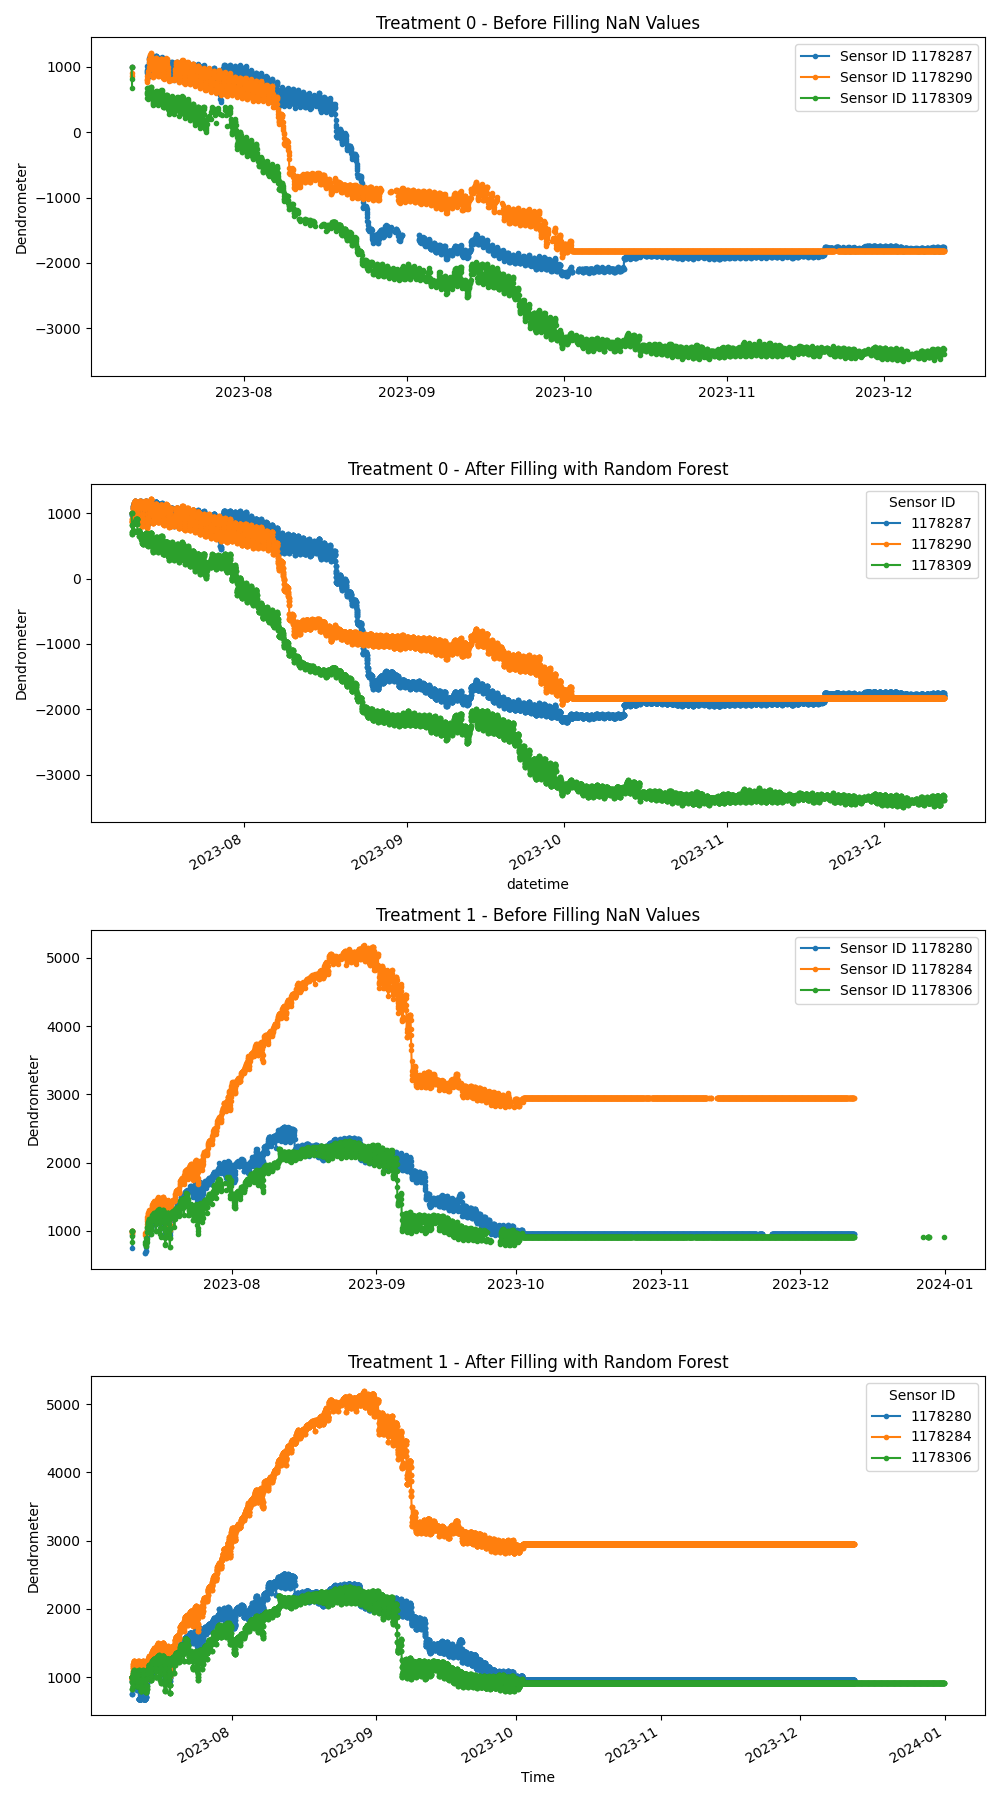

In [63]:
import matplotlib.pyplot as plt
final_df = final_df.sort_index()
# Define the figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 18))

# Define marker and linestyle
marker_style = '.'
linestyle_style = '-'

# Plot for treatment 0 before filling NaN values
# Filter the DataFrame for treatment 0
treatment_0_df = final_df[final_df['treatment'] == 0.0]

# Plot for treatment 0 before filling NaN values
for sensor_id, group in treatment_0_df.groupby('sensor_id'):
    group_data = group['dendrometer']
    group_data = group_data.where(pd.notna(group_data), None)  # Convert NaN to None for plotting
    axes[0].plot(group_data.index, group_data.values, marker=marker_style, linestyle=linestyle_style, label=f"Sensor ID {sensor_id}")

axes[0].set_title('Treatment 0 - Before Filling NaN Values')
axes[0].set_ylabel('Dendrometer')
axes[0].legend()

# Plot for treatment 0 after filling with Random Forest
# Group by sensor_id
grouped_data = treatment_0_df.groupby('sensor_id')

# Initialize an empty DataFrame to store the filled dendrometer data
filled_dendrometer_treatment_0 = pd.DataFrame(index=treatment_0_df.index)

# Iterate over groups
for sensor_id, group in grouped_data:
    # Apply fillna_randomforest to 'dendrometer' column for the current sensor_id group
    dendrometer_data = group['dendrometer']
    filled_dendrometer_treatment_0[sensor_id] = fillna_randomforest(dendrometer_data)

# Plot the filled data for each sensor ID for treatment 0
filled_dendrometer_treatment_0.plot(ax=axes[1], title='Treatment 0 - After Filling with Random Forest', marker=marker_style, linestyle=linestyle_style)
axes[1].set_ylabel('Dendrometer')
axes[1].legend(title='Sensor ID')

# Filter the DataFrame for treatment 1
treatment_1_df = final_df[final_df['treatment'] == 1.0]

# Plot for treatment 1 before filling NaN values
for sensor_id, group in treatment_1_df.groupby('sensor_id'):
    group_data = group['dendrometer']
    group_data = group_data.where(pd.notna(group_data), None)  # Convert NaN to None for plotting
    axes[2].plot(group_data.index, group_data.values, marker=marker_style, linestyle=linestyle_style, label=f"Sensor ID {sensor_id}")

axes[2].set_title('Treatment 1 - Before Filling NaN Values')
axes[2].set_ylabel('Dendrometer')
axes[2].legend()

# Plot for treatment 1 after filling with Random Forest
# Group by sensor_id
grouped_data = treatment_1_df.groupby('sensor_id')

# Initialize an empty DataFrame to store the filled dendrometer data
filled_dendrometer_treatment_1 = pd.DataFrame(index=treatment_1_df.index)

# Iterate over groups
for sensor_id, group in grouped_data:
    # Apply fillna_randomforest to 'dendrometer' column for the current sensor_id group
    dendrometer_data = group['dendrometer']
    filled_dendrometer_treatment_1[sensor_id] = fillna_randomforest(dendrometer_data)

# Plot the filled data for each sensor ID for treatment 1
filled_dendrometer_treatment_1.plot(ax=axes[3], title='Treatment 1 - After Filling with Random Forest', marker=marker_style, linestyle=linestyle_style)
axes[3].set_ylabel('Dendrometer')
axes[3].set_xlabel('Time')
axes[3].legend(title='Sensor ID')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


In [64]:
# Initialize an empty DataFrame to store outlier detection results
outlier_detection_results = pd.DataFrame(index=filled_dendrometer.index, columns=filled_dendrometer.columns)

# Define the window length - a short window because we want to detect short-term outliers
window_length = 6

# Perform sliding window operation for each sensor ID
for sensor_id, data in filled_dendrometer.items():
    # Calculate rolling mean and standard deviation
    rolling_mean = data.rolling(window=window_length, min_periods=1, center=True).mean()
    rolling_std = data.rolling(window=window_length, min_periods=1, center=True).std()
    
    # Calculate upper and lower bounds for outlier detection
    upper_bound = rolling_mean + 2 * rolling_std
    lower_bound = rolling_mean - 2 * rolling_std
    
    # Identify outliers
    outliers = (data > upper_bound) | (data < lower_bound)
    
    # Store outlier detection results
    outlier_detection_results[sensor_id] = outliers

# print the number of outliers detected for each sensor
print(outlier_detection_results.sum())



1178280     89
1178284     93
1178287    248
1178290     78
1178306     76
1178309    120
dtype: int64


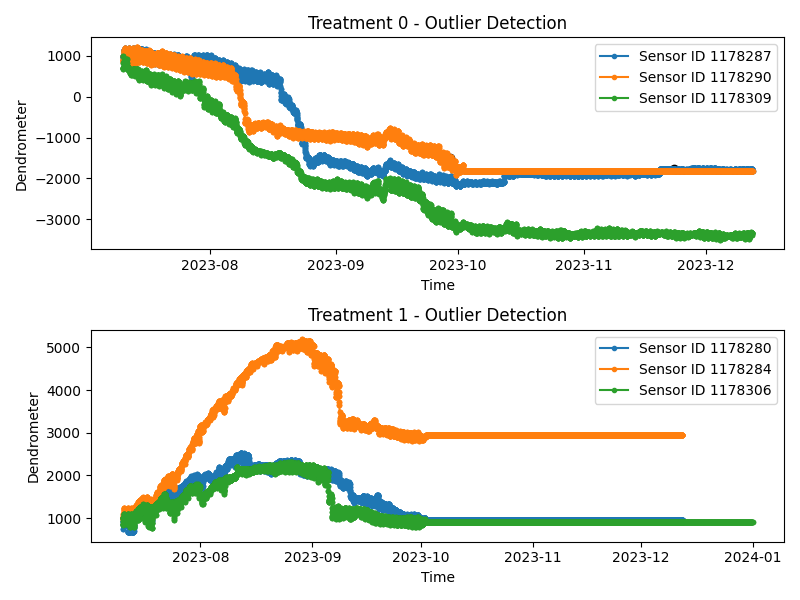

Outliers for Treatment 0:
Index: 2023-11-23 01:00:00, Value: -1767.9
Index: 2023-09-29 03:00:00, Value: -1491.81

Outliers for Treatment 1:


In [65]:
import matplotlib.pyplot as plt
plt.clf()

# Define marker style
marker_style = '.'

# Define color for outlier points
outlier_color = 'black'

# Empty lists to collect outlier values and their indices
outliers_treatment_0 = []
outliers_treatment_1 = []

# Plot the results for treatment 0
plt.figure(figsize=(8, 6))

# Subplot for treatment 0
plt.subplot(2, 1, 1)

# Plot dendrometer data for each sensor ID
for sensor_id, data in filled_dendrometer_treatment_0.items():
    # Calculate rolling mean and standard deviation
    rolling_mean = data.rolling(window=window_length, min_periods=1, center=True).mean()
    rolling_std = data.rolling(window=window_length, min_periods=1, center=True).std()
    
    # Calculate upper and lower bounds for outlier detection
    upper_bound = rolling_mean + 2 * rolling_std
    lower_bound = rolling_mean - 2 * rolling_std
    
    # Plot dendrometer data without connecting lines
    plt.plot(data.index, data.values, marker=marker_style, label=f"Sensor ID {sensor_id}")
    
    # Identify outliers
    outliers = (data > upper_bound) | (data < lower_bound)
    
    # Collect outlier values and indices
    outliers_data = data[outliers]
    outliers_index = outliers_data.index
    outliers_treatment_0.extend(list(zip(outliers_index, outliers_data)))
    
    # Mark outliers in black
    plt.scatter(outliers_index, outliers_data.values, color=outlier_color)

plt.title('Treatment 0 - Outlier Detection')
plt.xlabel('Time')
plt.ylabel('Dendrometer')
plt.legend()

# Plot the results for treatment 1
# Subplot for treatment 1
plt.subplot(2, 1, 2)

# Plot dendrometer data for each sensor ID
for sensor_id, data in filled_dendrometer_treatment_1.items():
    # Calculate rolling mean and standard deviation
    rolling_mean = data.rolling(window=window_length, min_periods=1, center=True).mean()
    rolling_std = data.rolling(window=window_length, min_periods=1, center=True).std()
    
    # Calculate upper and lower bounds for outlier detection
    upper_bound = rolling_mean + 2 * rolling_std
    lower_bound = rolling_mean - 2 * rolling_std
    
    # Plot dendrometer data without connecting lines
    plt.plot(data.index, data.values, marker=marker_style, label=f"Sensor ID {sensor_id}")
    
    # Identify outliers
    outliers = (data > upper_bound) | (data < lower_bound)
    
    # Collect outlier values and indices
    outliers_data = data[outliers]
    outliers_index = outliers_data.index
    outliers_treatment_1.extend(list(zip(outliers_index, outliers_data)))
    
    # Mark outliers in black
    plt.scatter(outliers_index, outliers_data.values, color=outlier_color)

plt.title('Treatment 1 - Outlier Detection')
plt.xlabel('Time')
plt.ylabel('Dendrometer')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

# Print outliers with their indices
print("Outliers for Treatment 0:")
for index, value in outliers_treatment_0:
    print(f"Index: {index}, Value: {value}")

print("\nOutliers for Treatment 1:")
for index, value in outliers_treatment_1:
    print(f"Index: {index}, Value: {value}")


In [66]:
# Iterate over each sensor ID to replace outliers with the rolling mean - we do that because it is crucial to keep the sensetivity of the data
#if we want to accuratly calculate MDS
for sensor_id in filled_dendrometer.columns:
    # Get the sensor data
    data = filled_dendrometer[sensor_id]
    
    # Get the rolling mean for the sensor data
    rolling_mean = data.rolling(window=window_length, min_periods=1, center=True).mean()
    
    # Identify outliers
    outliers = outlier_detection_results[sensor_id]
    
    # Replace outliers with the rolling mean
    data[outliers] = rolling_mean[outliers]
    
    # Store the adjusted data back
    filled_dendrometer[sensor_id] = data


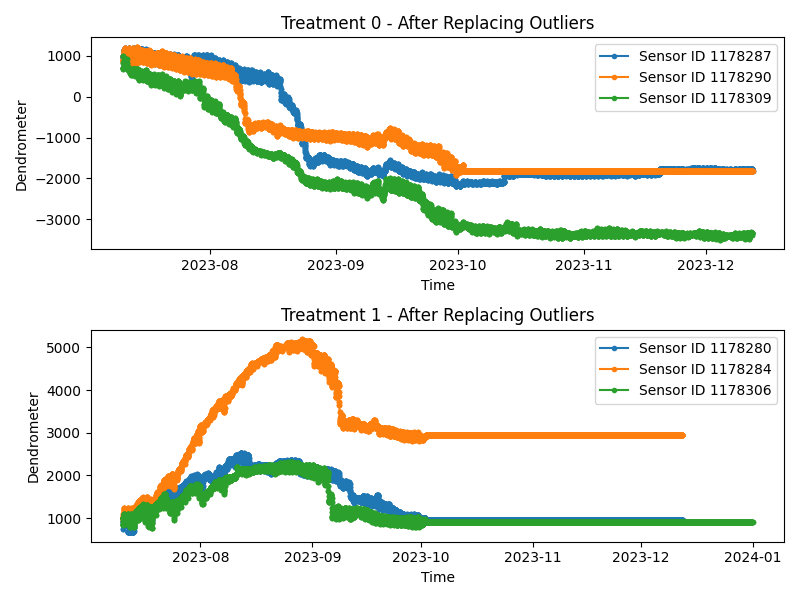

In [67]:
import matplotlib.pyplot as plt
plt.clf()

# Define marker style
marker_style = '.'
data = data.sort_index()
# Plot the results for treatment 0
plt.figure(figsize=(8, 6))

# Subplot for treatment 0
plt.subplot(2, 1, 1)

# Plot dendrometer data for each sensor ID
for sensor_id, data in filled_dendrometer_treatment_0.items():
    plt.plot(data.index, data.values, marker=marker_style, label=f"Sensor ID {sensor_id}")

plt.title('Treatment 0 - After Replacing Outliers')
plt.xlabel('Time')
plt.ylabel('Dendrometer')
plt.legend()

# Plot the results for treatment 1
# Subplot for treatment 1
plt.subplot(2, 1, 2)

# Plot dendrometer data for each sensor ID
for sensor_id, data in filled_dendrometer_treatment_1.items():
    plt.plot(data.index, data.values, marker=marker_style, label=f"Sensor ID {sensor_id}")

plt.title('Treatment 1 - After Replacing Outliers')
plt.xlabel('Time')
plt.ylabel('Dendrometer')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


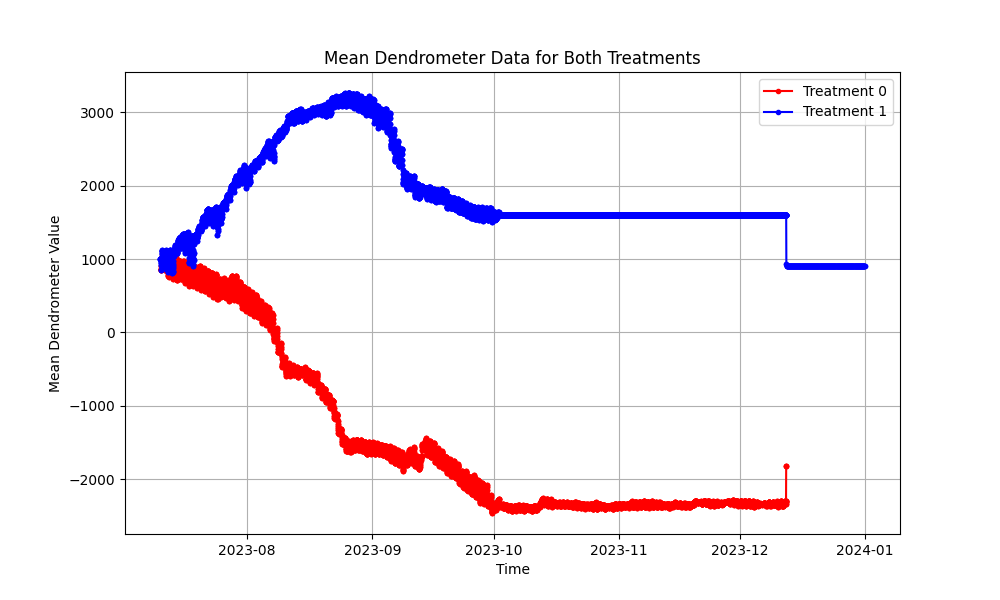

In [68]:
import matplotlib.pyplot as plt

# Calculate the mean of the three sensors for each treatment
mean_treatment_0 = filled_dendrometer_treatment_0.mean(axis=1)
mean_treatment_1 = filled_dendrometer_treatment_1.mean(axis=1)

# Plot the results on a single plot
plt.figure(figsize=(10, 6))
plt.plot(mean_treatment_0.index, mean_treatment_0.values, label='Treatment 0', color='red', marker='.')
plt.plot(mean_treatment_1.index, mean_treatment_1.values, label='Treatment 1', color='blue', marker='.')
plt.title('Mean Dendrometer Data for Both Treatments')
plt.xlabel('Time')
plt.ylabel('Mean Dendrometer Value')
plt.legend()
plt.grid(True)  # Optional, adds gridlines for better readability

# Show the plot
plt.show()


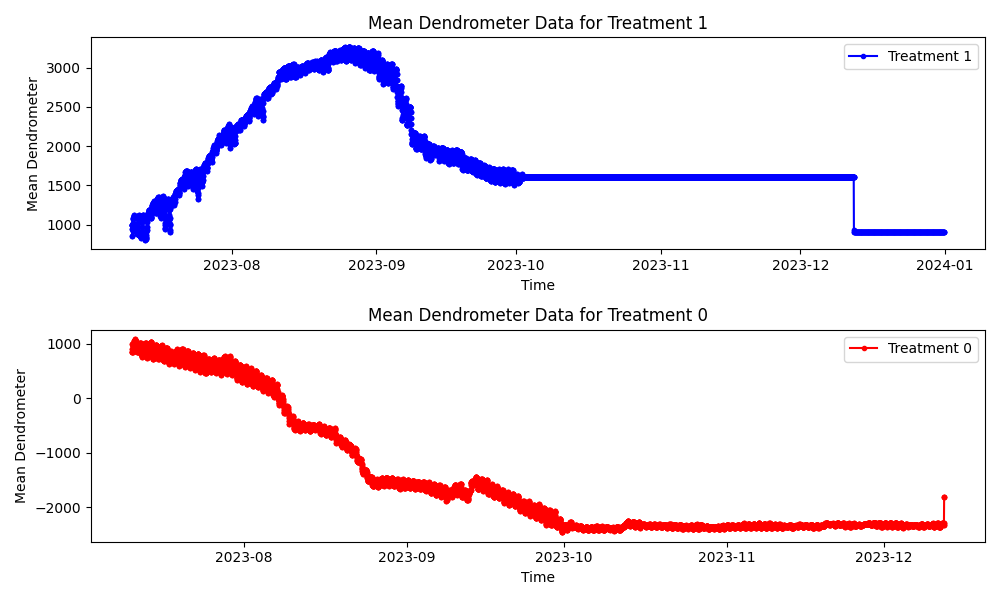

In [69]:
import matplotlib.pyplot as plt
# another way of visualizing the mean
# Calculate the mean of the three sensors for each treatment
mean_treatment_0 = filled_dendrometer_treatment_0.mean(axis=1)
mean_treatment_1 = filled_dendrometer_treatment_1.mean(axis=1)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot for treatment 0
plt.subplot(2, 1, 2)
plt.plot(mean_treatment_0.index, mean_treatment_0.values, label='Treatment 0', color='red', marker = '.')
plt.title('Mean Dendrometer Data for Treatment 0')
plt.xlabel('Time')
plt.ylabel('Mean Dendrometer')
plt.legend()

# Plot for treatment 1
plt.subplot(2, 1, 1)
plt.plot(mean_treatment_1.index, mean_treatment_1.values, label='Treatment 1', color='blue', marker = '.')
plt.title('Mean Dendrometer Data for Treatment 1')
plt.xlabel('Time')
plt.ylabel('Mean Dendrometer')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


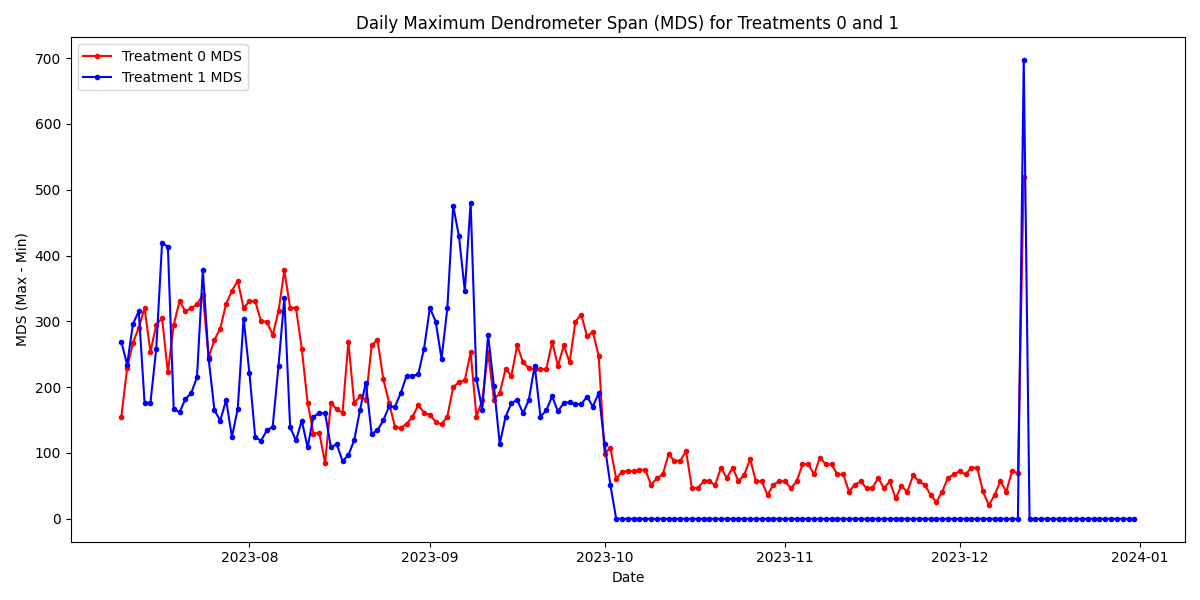

In [70]:
import pandas as pd

# Resample by day and calculate daily max - min for Treatment 0
daily_mds_treatment_0 = mean_treatment_0.resample('D').apply(lambda x: x.max() - x.min())

# Resample by day and calculate daily max - min for Treatment 1
daily_mds_treatment_1 = mean_treatment_1.resample('D').apply(lambda x: x.max() - x.min())

# Plotting
plt.figure(figsize=(12, 6))

# Plot daily MDS for both treatments
plt.plot(daily_mds_treatment_0.index, daily_mds_treatment_0.values, label='Treatment 0 MDS', color='red', marker='.')
plt.plot(daily_mds_treatment_1.index, daily_mds_treatment_1.values, label='Treatment 1 MDS', color='blue', marker='.')

plt.title('Daily Maximum Dendrometer Span (MDS) for Treatments 0 and 1')
plt.xlabel('Date')
plt.ylabel('MDS (Max - Min)')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


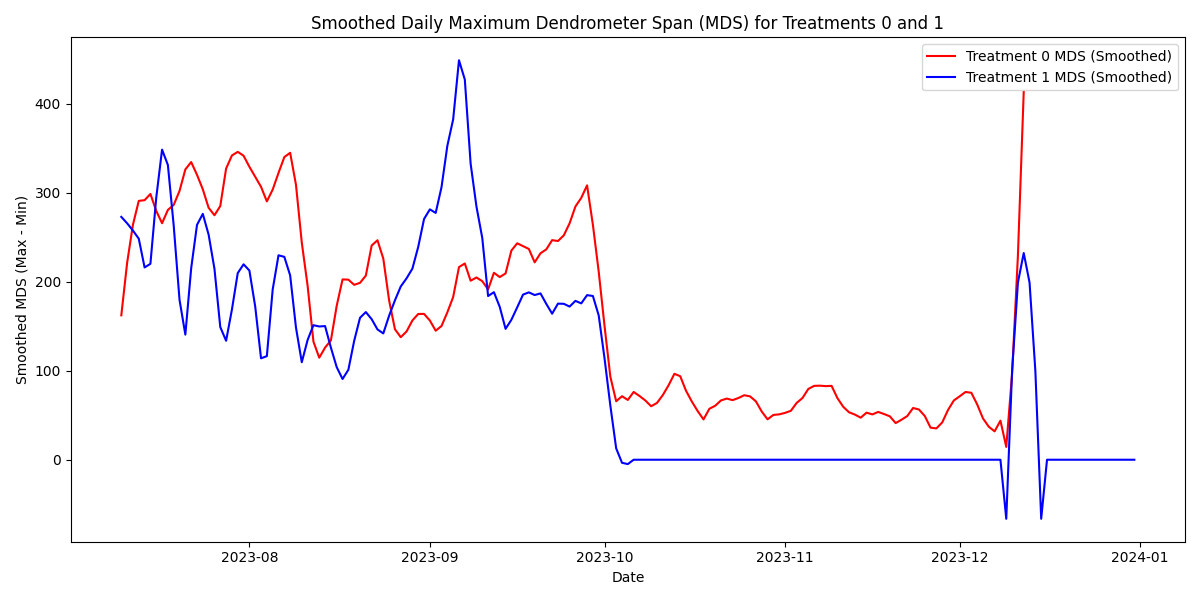

In [71]:
from scipy.signal import savgol_filter

# Parameters for Savitzky-Golay smoothing
window_length = 7  # one week window
polyorder = 2  # we axpect a parabula shape

# Apply Savitzky-Golay filter to smooth the MDS series
smoothed_mds_treatment_0 = savgol_filter(daily_mds_treatment_0, window_length, polyorder)
smoothed_mds_treatment_1 = savgol_filter(daily_mds_treatment_1, window_length, polyorder)

# Plotting the smoothed MDS
plt.figure(figsize=(12, 6))

# Plot smoothed MDS for both treatments
plt.plot(daily_mds_treatment_0.index, smoothed_mds_treatment_0, label='Treatment 0 MDS (Smoothed)', color='red')
plt.plot(daily_mds_treatment_1.index, smoothed_mds_treatment_1, label='Treatment 1 MDS (Smoothed)', color='blue')

plt.title('Smoothed Daily Maximum Dendrometer Span (MDS) for Treatments 0 and 1')
plt.xlabel('Date')
plt.ylabel('Smoothed MDS (Max - Min)')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


# tansiometers
### ("volumetric soil moisture meter" to be more accurate)

In [1]:
#read tansiometer data

import pandas as pd
tansyometer1 = pd.read_excel('tansyometers_report.xlsx')
tansyometer1.head()


,project_id,depth_cm,measurement_type,inner_index,sensor_id,format,project_name,date_time
0,878405,15,moisture,0,1174921,10.80,106,2023-06-01 13:00:00
1,878405,15,moisture,0,1174921,10.25,106,2023-06-01 14:00:00
2,878405,15,moisture,0,1174921,9.90,106,2023-06-01 15:00:00
3,878405,15,moisture,0,1174921,9.70,106,2023-06-01 16:00:00
4,878405,15,moisture,0,1174921,9.50,106,2023-06-01 17:00:00


In [2]:
# Convert 'datetime' column to datetime format and set as index
tansyometer1['date_time'] = pd.to_datetime(tansyometer1['date_time'], dayfirst=True)
tansyometer1.set_index('date_time', inplace=True)
tansyometer1 = tansyometer1.sort_index()
print('volumetric soil moisture data: ')
print('shape:', tansyometer1.shape)
tansyometer1.head()

volumetric soil moisture data: 
shape: (414536, 7)


,project_id,depth_cm,measurement_type,inner_index,sensor_id,format,project_name
date_time,,,,,,,
2023-06-01 13:00:00,878405,15,moisture,0,1174921,10.80,106
2023-06-01 13:00:00,892693,30,moisture,1,1174921,40.55,106
2023-06-01 13:00:00,878405,15,Temp,6,1174921,28.30,106
2023-06-01 13:00:00,892693,30,Temp,7,1174921,24.90,106
2023-06-01 13:00:00,892693,45,moisture,2,1174921,41.20,106


In [3]:
#filter the data to leave only project_name with value and 102 (treatment 1)
tansyometer = tansyometer1[tansyometer1['project_name'].isin([102])]
#add treatment column and assign values based on project_name:  102 - 1.0
tansyometer['treatment'] = tansyometer['project_name'].map({102: 1.0})    

<ipython-input-3-3eeeab1239ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tansyometer['treatment'] = tansyometer['project_name'].map({102: 1.0})


<Figure size 432x288 with 0 Axes>

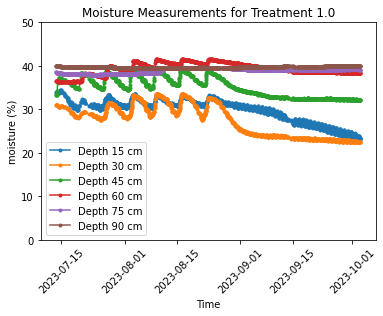

In [4]:
# Filter rows with measurement_type == 'moisture' (there are also measurments of temperature we will not discuss)
import matplotlib.pyplot as plt
moisture_data = tansyometer[tansyometer['measurement_type'] == 'moisture']

plt.clf()
plt.figure(figsize = (6,4))
# Plot 
# Group by depth_cm and plot format against index
for depth, group in moisture_data.groupby('depth_cm'):
    plt.plot(group.index, group['format'], label=f'Depth {depth} cm', marker = '.')

# Add title and labels
plt.title(f'Moisture Measurements for Treatment 1.0')
plt.xlabel('Time')
plt.ylabel('moisture (%)')
plt.ylim(0, 50)
# Add legend
plt.legend()
#rotate the x labels
plt.xticks(rotation=45)

    # Show plot
plt.show()


In [5]:
# we want to add the missing rows so that we can see the gaps in the data

# Group by 'depth_cm'
grouped_data = moisture_data.groupby('depth_cm')

# List to store modified dataframes for each sensor_id
modified_data = []

# Iterate over each group
for depth_cm, group in grouped_data:
    # Aggregate the data within each group to handle duplicates (29/10 clock replacement)
    aggregated_group = group.groupby(group.index).mean()
    
    # Resample the aggregated group at hourly intervals
    resampled_group = aggregated_group.resample('H').asfreq()
    
    # Fill NaN in 'format' column
    resampled_group['format'] = resampled_group['format'].fillna(value=pd.NA)
    
    # Insert rows for missing timestamps
    expected_index = pd.date_range(start=resampled_group.index.min(), end=resampled_group.index.max(), freq='H')
    missing_timestamps = expected_index.difference(resampled_group.index)
    for ts in missing_timestamps:
        # Extract treatment value for the group
        treatment_value = group['treatment'].iloc[0]
        # Create a new row with NaN value in 'format' column and the respective depth and treatment
        new_row = pd.DataFrame({'format': pd.NA, 'treatment': treatment_value}, index=[ts])
        # Append the new row to the dataframe
        resampled_group = pd.concat([resampled_group, new_row])
    
    # Add depth_cm column
    resampled_group['depth_cm'] = depth_cm
    
    # Store the modified group
    modified_data.append(resampled_group)

# Concatenate the modified data for all deapths into a single DataFrame
final_df = pd.concat(modified_data)

# Sort the DataFrame 
final_df = final_df.sort_index()

In [19]:
# count missing values
# Group by depth_cm
grouped_data_t = final_df.groupby('depth_cm')

# Initialize an empty DataFrame to store the filled tansyometer data
filled_tansyometer = pd.DataFrame(index=final_df.index)

# Iterate over groups
for depth_cm, group in grouped_data_t:
    # Apply fillna_randomforest to 'tansyometer' column for the current depth_cm group
    tansyometer_data = group['format']
    filled_tansyometer[depth_cm] = fillna_randomforest(tansyometer_data)

# Initialize an empty dictionary to store the count of missing values for each sensor
missing_values_count = {}

# Iterate over each sensor group
for depth_cm, group in final_df.groupby('depth_cm'):
    # Count the number of missing values for the current sensor
    missing_count = group['format'].isnull().sum()
    missing_values_count[depth_cm] = missing_count

# Print the count of missing values for each sensor
for depth_cm, missing_count in missing_values_count.items():
    print(f"depth {depth_cm}: {missing_count} missing values")

depth 15: 573 missing values
depth 30: 815 missing values
depth 45: 812 missing values
depth 60: 809 missing values
depth 75: 734 missing values
depth 90: 734 missing values


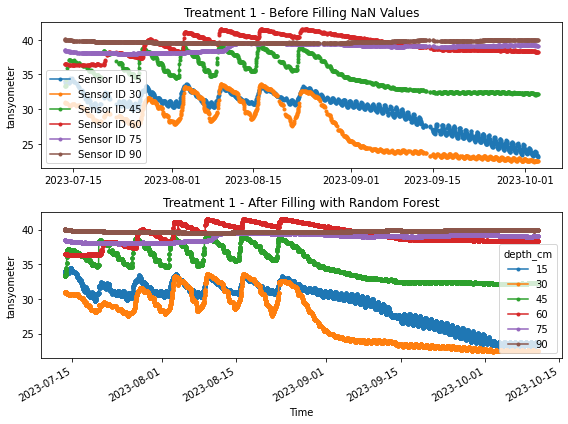

In [20]:
# Fill the gaps
import matplotlib.pyplot as plt

# Define the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Define marker and linestyle
marker_style = '.'
linestyle_style = '-'

# Plot for treatment 1 before filling NaN values
for depth_cm, group in final_df.groupby('depth_cm'):
    group_data = group['format']
    group_data = group_data.where(pd.notna(group_data), None)  # Convert NaN to None for plotting
    axes[0].plot(group_data.index, group_data.values, marker=marker_style, linestyle=linestyle_style, label=f"Sensor ID {depth_cm}")

axes[0].set_title('Treatment 1 - Before Filling NaN Values')
axes[0].set_ylabel('tansyometer')
axes[0].legend()

# Plot for treatment 1 after filling with Random Forest
# Group by depth_cm
grouped_data = final_df.groupby('depth_cm')

# Initialize an empty DataFrame to store the filled format data
filled_tansyometer = pd.DataFrame(index=final_df.index)

# Iterate over groups
for depth_cm, group in grouped_data:
    # Apply fillna_randomforest to 'format' column for the current depth_cm group
    tansyometer_data = group['format']
    filled_tansyometer[depth_cm] = fillna_randomforest(tansyometer_data)

# Plot the filled data for each sensor ID for treatment 1
filled_tansyometer.plot(ax=axes[1], title='Treatment 1 - After Filling with Random Forest', marker=marker_style, linestyle=linestyle_style)
axes[1].set_ylabel('tansyometer')
axes[1].set_xlabel('Time')
axes[1].legend(title='depth_cm')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


In [21]:
# Convert all columns that should be numeric to numeric type
for column in filled_tansyometer.columns:
    filled_tansyometer[column] = pd.to_numeric(filled_tansyometer[column], errors='coerce')

# Now, group by the index and calculate the mean
filled_tansyometer = filled_tansyometer.groupby(filled_tansyometer.index).mean()


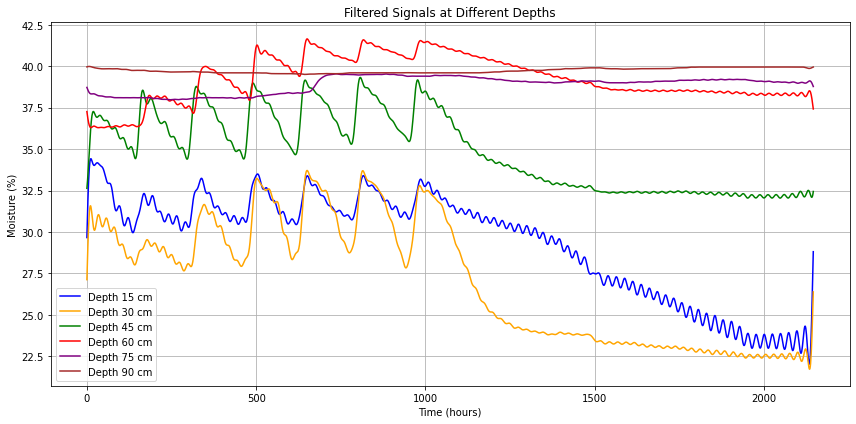

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the cutoff frequency
cutoff = 1.0 / 24  # converting to cycles per hour

def apply_low_pass_filter(data, dt, cutoff):
    N = len(data)
    yf = np.fft.fft(data)
    xf = np.fft.fftfreq(N, dt)

    # Apply low-pass filter
    mask = (np.abs(xf) > cutoff)
    yf_filtered = yf.copy()
    yf_filtered[mask] = 0.0

    # Inverse FFT to reconstruct the signal
    filtered_signal = np.fft.ifft(yf_filtered)
    return filtered_signal.real  # Return only the real part

# Depths to analyze
depths = [15, 30, 45, 60, 75, 90]

# Initialize an empty DataFrame to store filtered signals
filtered_df = pd.DataFrame()

# Sampling interval in days (assuming hourly data)
dt = 1.0 # hours to days

for i, depth in enumerate(depths):
    # Extract data for the current depth and convert to float
    data = filled_tansyometer[depth].astype(float).dropna().values

    # Apply the low-pass filter
    signal_filtered = apply_low_pass_filter(data, dt, cutoff)

    # Add the filtered data to the DataFrame with an appropriate column name
    filtered_df[f'Depth {depth} cm'] = pd.Series(signal_filtered)

# Plot setup
plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']  # Colors for the plot lines
labels = [f'Depth {depth} cm' for depth in depths]  # Labels for the legend

for i, column in enumerate(filtered_df.columns):
    plt.plot(np.arange(len(filtered_df[column])) * dt, filtered_df[column], label=labels[i], color=colors[i])

plt.title('Filtered Signals at Different Depths')
plt.xlabel('Time (hours)')
plt.ylabel('Moisture (%)')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()



In [23]:
#detrend the data

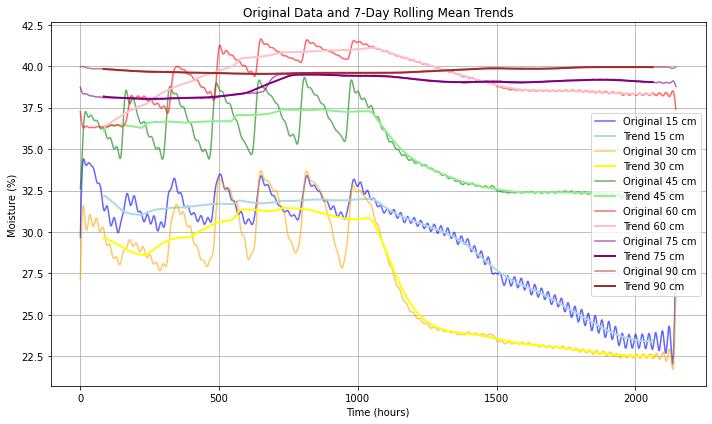

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate 7-day rolling mean and add as new columns
for depth in [15, 30, 45, 60, 75, 90]:
    original_column_name = f'Depth {depth} cm'
    trend_column_name = f'{depth} trend'
    filtered_df[trend_column_name] = filtered_df[original_column_name].rolling(window=168, center = True).mean()

# Plot setup
plt.figure(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']  # Colors for the original data lines
trend_colors = ['lightblue', 'yellow', 'lightgreen', 'pink', 'purple', 'brown']  # Colors for the trend lines

for i, depth in enumerate([15, 30, 45, 60, 75, 90]):
    original_column_name = f'Depth {depth} cm'
    trend_column_name = f'{depth} trend'

    # Plot the original data
    plt.plot(filtered_df.index, filtered_df[original_column_name], label=f'Original {depth} cm', color=colors[i], alpha=0.6)

    # Plot the trend data
    plt.plot(filtered_df.index, filtered_df[trend_column_name], label=f'Trend {depth} cm', color=trend_colors[i], linewidth=2)

plt.title('Original Data and 7-Day Rolling Mean Trends')
plt.xlabel('Time (hours)')
plt.ylabel('Moisture (%)')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


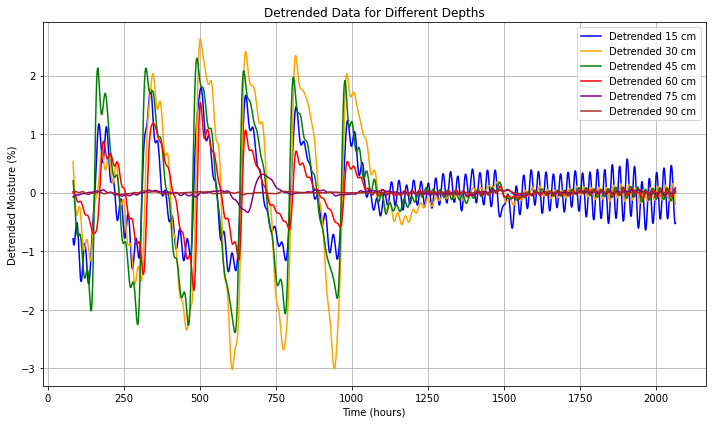

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate detrended data and add as new columns
for depth in [15, 30, 45, 60, 75, 90]:
    original_column_name = f'Depth {depth} cm'
    trend_column_name = f'{depth} trend'
    detrended_column_name = f'{depth} detrended'
    
    # Subtracting the trend from the original data to get the detrended data
    filtered_df[detrended_column_name] = filtered_df[original_column_name] - filtered_df[trend_column_name]

# Plot setup
plt.figure(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']  # Colors for the detrended data lines

for i, depth in enumerate([15, 30, 45, 60, 75, 90]):
    detrended_column_name = f'{depth} detrended'

    # Plot the detrended data
    plt.plot(filtered_df.index, filtered_df[detrended_column_name], label=f'Detrended {depth} cm', color=colors[i])

plt.title('Detrended Data for Different Depths')
plt.xlabel('Time (hours)')
plt.ylabel('Detrended Moisture (%)')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


In [26]:
# Filtering the DataFrame to only the first 1100 rows (this is the irrigation period - everything else has a different periodicity)
filtered_df = filtered_df.iloc[:1100]


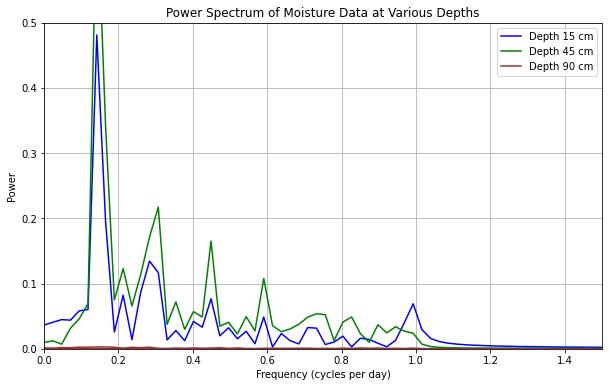

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def my_dft(signal, dt):
    N = len(signal)
    k_index = np.arange(N)
    n = np.arange(N)
    F = []
    for ki in k_index:
        expon = np.exp(-2.0*np.pi*1j * ki * n / N)
        Fk = np.sum(signal * expon)
        F.append(Fk)
    k = build_k(N, dt)
    return k, np.array(F)/N

def build_k(N, dt):
    if N % 2 == 0:
        k = np.hstack([np.arange(0, N//2),
                       np.arange(-N//2, 0)])
    else:
        k = np.hstack([np.arange(0, (N-1)//2 + 1),
                       np.arange(-(N-1)//2, 0)])
    return k / (dt * N)

# Depths to analyze
depths = [15, 45, 90]
colors = ['blue', 'green', 'brown']  # Different colors for each plot

# Plot setup
plt.figure(figsize=(10, 6))

# Sampling interval in days (assuming hourly data)
dt = 1.0 / 24

for depth, color in zip(depths, colors):
    # Extract data for the current depth and convert to float
    data = filtered_df[f'{depth} detrended'].astype(float).dropna().values

    # Apply the DFT function
    k_dft, dft = my_dft(data, dt)
    dft_abs = np.abs(dft)

    # Plot the result
    plt.plot(k_dft, dft_abs, label=f'Depth {depth} cm', color=color)

# Configure plot
plt.title("Power Spectrum of Moisture Data at Various Depths")
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Power")
plt.ylim(0, 0.5)  # Limit the y-axis for better visualization
plt.xlim(0, 1.5)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [37]:
#choose the 45 cm depth and study the signal

import pandas as pd
from statsmodels.tsa.stattools import adfuller


series = filled_tansyometer[45][:1100]

# Perform Augmented Dickey-Fuller test
result = adfuller(series.dropna())  
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation of results
if result[1] < 0.05:
    print("Reject the null hypothesis (H0), the data does not have a unit root and is stationary.")
else:
    print("Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.")


ADF Statistic: -4.800459
p-value: 0.000054
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


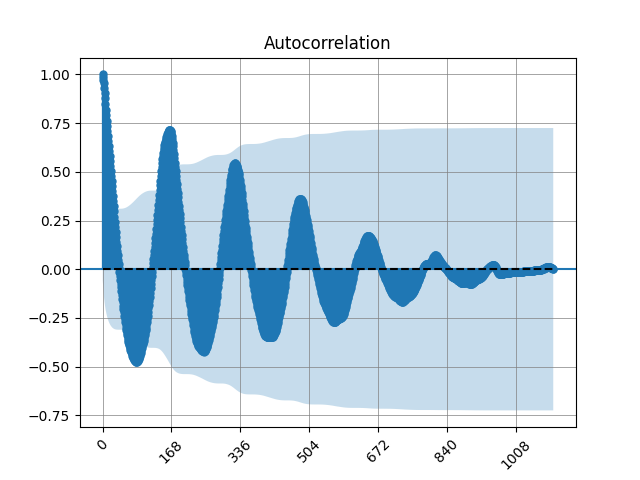

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm



# Example usage with your series, let's assume 'ar2_values' is defined and has values:
ar2_values = series
N = len(ar2_values)
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(ar2_values, lags= N-1, ax=ax, label="statsmodels", alpha=0.05, use_vlines=True)
ax.plot([0, N], [0]*2, color="black", ls="--")
# Add a vertical gridline every 168 points
ax.xaxis.set_major_locator(plt.MultipleLocator(168))
ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')  # Set grid style - 7 days interval

plt.xticks(rotation=45)
plt.show()



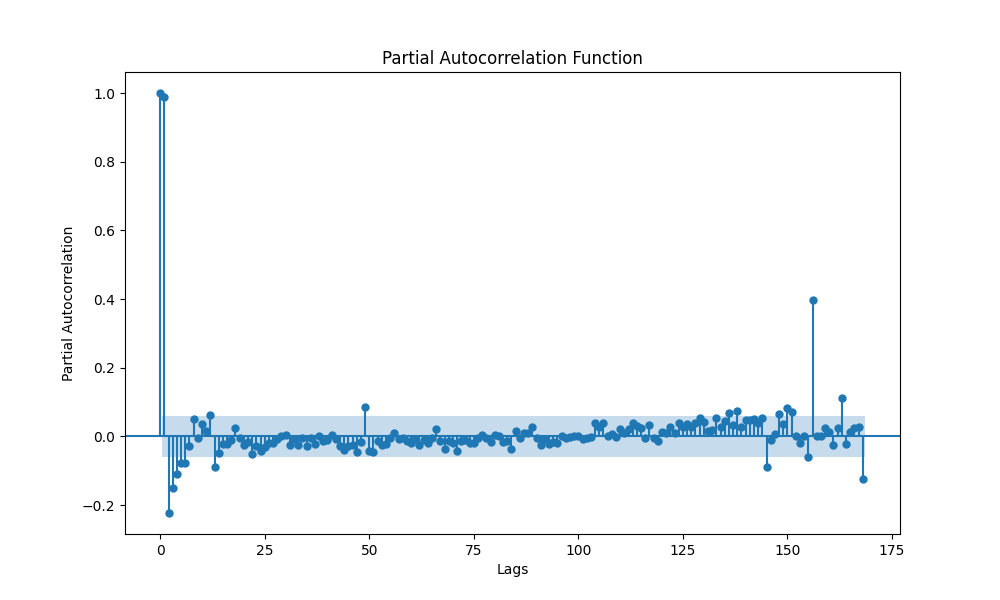

In [62]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf


# Plotting PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(series, ax=ax, lags=24*7) # 7 days of lags
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Setup and fit the ARIMA model
# Assuming p=1 (PACF resampeled by week - instead of 6 days it will be 1 week), d=0, q=1(ACF resampled by day, instead of 27 hours it will be 1 day)
model = sm.tsa.arima.ARIMA(ar2_values, order=(1, 0, 1))
fitted_model = model.fit()

# Print the summary of the model's fit
print(fitted_model.summary())


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                     45   No. Observations:                 1100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 445.563
Date:                Sun, 21 Apr 2024   AIC                           -883.126
Time:                        10:25:13   BIC                           -863.114
Sample:                    07-13-2023   HQIC                          -875.556
                         - 08-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.5170      0.773     47.267      0.000      35.003      38.031
ar.L1          0.9910      0.006    173.953      0.000       0.980       1.002
ma.L1          0.2271      0.010     23.065      0.0

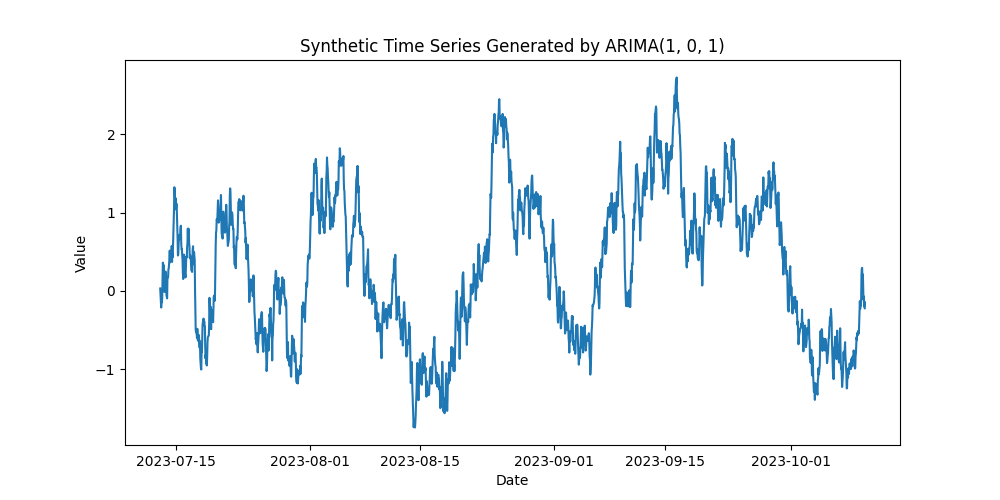

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(43)  # For reproducibility

# Define AR and MA parameters based on your ARIMA(1, 0, 1) model results
ar_params = np.array([1, -0.9910])  # AR part: 1 - 0.9982L
ma_params = np.array([1, 0.2271])   # MA part: 1 + 0.2116L

# Define ARMA process using the ArmaProcess class
arma_process = ArmaProcess(ar=ar_params, ma=ma_params)

# Generate synthetic data
n_samples = 2147  # Number of observations in your sample
synthetic_data = arma_process.generate_sample(nsample=n_samples, scale=np.sqrt(0.0143))

# Convert to pandas Series for easier plotting and handling
dates = pd.date_range(start='2023-07-13', periods=n_samples, freq='H')  # Assuming hourly data; adjust frequency as needed
synthetic_series = pd.Series(synthetic_data, index=dates)


# Plot the synthetic time series
plt.figure(figsize=(10, 5))
plt.plot(synthetic_series)
plt.title('Synthetic Time Series Generated by ARIMA(1, 0, 1)')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()


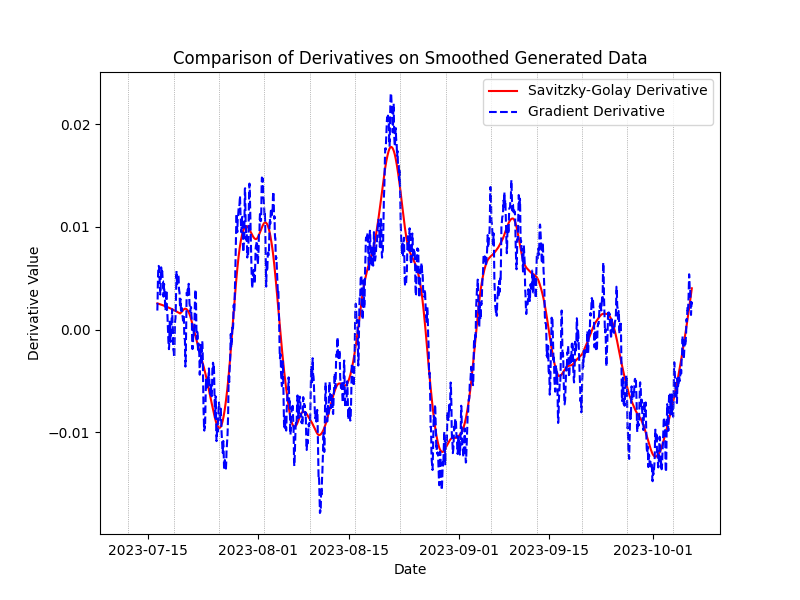

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Apply a rolling average to smooth the data
rolling_window_size = 24*7  # Define the rolling window size
smoothed_series = synthetic_series.rolling(window=rolling_window_size, center=True).mean().dropna()

# Calculate derivative using the Savitzky-Golay filter
window_size = 24*7+1  
poly_order = 3   
savgol_derivative = savgol_filter(smoothed_series, window_length=window_size, polyorder=poly_order, deriv=1)

# Calculate derivative using numpy's gradient
time_step = 1  # This should match the frequency of the data points
gradient_derivative = np.gradient(smoothed_series, time_step)

# Plotting both derivatives
plt.figure(figsize=(8, 6))
plt.plot(smoothed_series.index, savgol_derivative, label='Savitzky-Golay Derivative', color='red')
plt.plot(smoothed_series.index, gradient_derivative, label='Gradient Derivative', color='blue', linestyle='--')

# Define the start date for vertical lines
start_date = pd.to_datetime("2023-07-12")

# Add vertical lines every 7 days starting from 'start_date'
current_date = start_date
while current_date <= smoothed_series.index.max():
    plt.axvline(current_date, color='gray', linestyle=':', linewidth=0.5)
    current_date += pd.Timedelta(days=7)

plt.title('Comparison of Derivatives on Smoothed Generated Data')
plt.xlabel('Date')
plt.ylabel('Derivative Value')
plt.legend()
plt.show()
